# Introduction

problem setup describtion



this book is to show how to use cross validation as a means to detpngermine the hyperparameter alpha.

<img src="intro-pics/how_insar_works.jpg"  width="400" />
sdadas
sadasdasd


<img src="intro-pics/equation.png" width="100" />


In [195]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.model_selection import KFold

sns.set()
sns.set_style('white')

### load matrix G,d,L

In [196]:
tmp = loadmat('obs_G.mat')
G = tmp['obs_G']

tmp = loadmat('obs_u.mat')
d = tmp['obs_u']
n_d = len(d)

tmp = loadmat('laplacian.mat')
L = tmp['laplacian']

## L curve method

In [207]:
d_pseudo = np.zeros((320,1))
d_concat = np.vstack((d,d_pseudo))

In [208]:
alpha_vec = [0.0001,0.001,0.01,0.1,0.25,0.5,1,1.5,2,2.5,3,4,6,10];
idx = [1,4,12]
n = len(alpha_vec)
misfit_vec = np.zeros(n)

for i in range(n):
    G_concat = np.vstack((G,alpha_vec[i]*L));
    #m = (G_'*G_)\(G_'*d_);
    m = np.linalg.lstsq(G_concat, d_concat, rcond=None)[0]
    
    v = d - np.dot(G,m);
    misfit_vec[i] = np.dot(v.T,v);

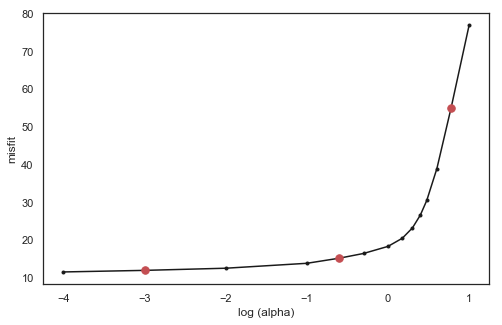

In [209]:
plt.figure(figsize=(8,5))
plt.plot(np.log10(alpha_vec),misfit_vec,'k.-')
plt.plot(np.log10(np.take(alpha_vec,idx)),np.take(misfit_vec,idx),'r.',markersize=15)
plt.xlabel('log (alpha)')
plt.ylabel('misfit')
plt.show()

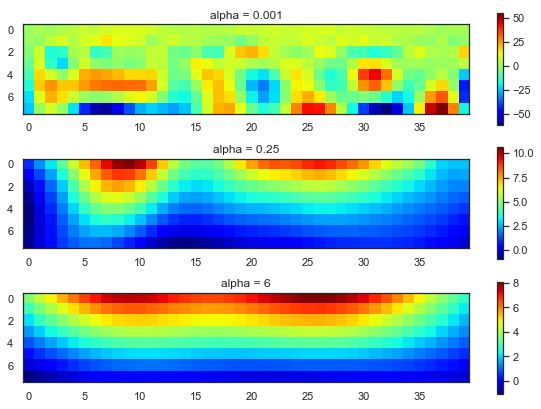

In [210]:
plt.figure(figsize=(10,7))

for i in range(3):
    alpha = alpha_vec[idx[i]]
    G_concat = np.vstack((G,alpha*L));
    m = np.linalg.lstsq(G_concat, d_concat, rcond=None)[0]
    m_ = np.reshape(m,(40,8)).T
    
    plt.subplot(3,1,i+1)
    plt.imshow(m_,cmap=plt.cm.jet)
    plt.title('alpha = {}'.format(alpha))
    plt.colorbar()
    
plt.show()

## Cross validation method

In [214]:
rms_train = np.zeros(n)
rms_test = np.zeros(n)

K = 5
for i in range(n):
    alpha = alpha_vec[i]
    
    misfit_train_vec = np.zeros(K)
    misfit_test_vec = np.zeros(K)

    kf = KFold(n_splits=K, random_state=False, shuffle=True)
    j = 0
    for idx_test,idx_train in kf.split(range(6000)):
        d_test = np.take(d,idx_test,axis=0)
        G_test = np.take(G,idx_test,axis=0)

        d_train = np.take(d,idx_train,axis=0)
        G_train = np.take(G,idx_train,axis=0)

        #print('d_test: {}, G_test: {}, d_train: {}, G_train {}'.format(d_test.shape,G_test.shape,d_train.shape,G_train.shape))

        d_concat = np.vstack((d_train,d_pseudo))
        G_concat = np.vstack((G_train,alpha*L))

        m = np.linalg.lstsq(G_concat, d_concat, rcond=None)[0]

        v_train = d_train - np.dot(G_train,m);
        misfit_train_vec[j] = np.dot(v_train.T,v_train)/len(v_train);
        v_test = d_test - np.dot(G_test,m);
        misfit_test_vec[j] = np.dot(v_test.T,v_test)/len(v_test);

        j += 1
    #print('misfit_train_vec: {}, misfit_test_vec: {}'.format(misfit_train_vec,misfit_test_vec))

    rms_train[i] = np.mean(misfit_train_vec)
    rms_test[i] = np.mean(misfit_test_vec)
    #print('rms_train: {}, rms_test: {}'.format(rms_train,rms_test))
    #print('rms_ratio = {}'.format(rms_train/rms_test))
#print('rms_train: {}, rms_test: {}'.format(rms_train,rms_test))

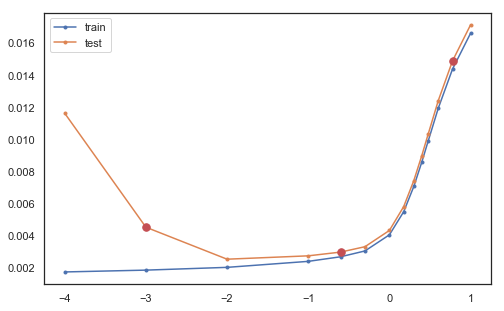

In [215]:
plt.figure(figsize=(8,5))
plt.plot(np.log10(alpha_vec),rms_train,'.-')
plt.plot(np.log10(alpha_vec),rms_test,'.-')
plt.plot(np.log10(np.take(alpha_vec,idx)),np.take(rms_test,idx),'r.',markersize=15)
plt.legend(('train','test'))
plt.show()

### Better test and train splits

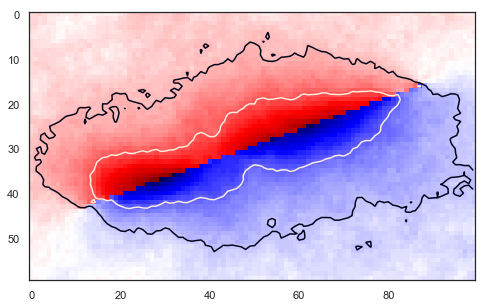

In [201]:
d_mat = np.reshape(d,(100,60)).T
plt.figure(figsize=(8,6))
plt.imshow(d_mat,cmap=plt.cm.seismic)
#plt.colorbar()
plt.contour(np.abs(d_mat),[0.36,0.9])
plt.show()